##1. Импортируйте необходимые модули:

In [6]:
!pip install gym
!pip install torch

import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from collections import deque
import random
import matplotlib.pyplot as plt


##2. Создайте нейронные сети для актора и критика:

In [7]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=-1)
        return x

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


##3. Создайте класс для управления обучением:

In [8]:
class ActorCriticAgent:
    def __init__(self, state_dim, action_dim, lr=1e-3, gamma=0.99):
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr)
        self.gamma = gamma
        self.memory = deque(maxlen=10000)

    def choose_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0)
        action_probs = self.actor(state)
        action = torch.multinomial(action_probs, 1).item()
        return action

    def store_transition(self, transition):
        self.memory.append(transition)

    def learn(self):
        if len(self.memory) == 0:
            return

        state, action, reward, next_state, done = self.memory.pop()

        state = torch.FloatTensor(state).unsqueeze(0)
        next_state = torch.FloatTensor(next_state).unsqueeze(0)
        reward = torch.FloatTensor([reward])
        done = torch.FloatTensor([done])

        # Update critic
        value = self.critic(state)
        next_value = self.critic(next_state)
        target = reward + (1 - done) * self.gamma * next_value
        critic_loss = nn.MSELoss()(value, target.detach())

        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Update actor
        advantage = target - value
        action_prob = self.actor(state).gather(1, torch.LongTensor([[action]]))
        actor_loss = -torch.log(action_prob) * advantage.detach()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()


##4. Создайте функцию для обучения агента:

In [9]:
def train_agent(env_name, n_episodes=1000):
    env = gym.make(env_name)
    agent = ActorCriticAgent(env.observation_space.shape[0], env.action_space.n)
    reward_history = []

    for episode in range(n_episodes):
        state = env.reset()
        total_reward = 0

        while True:
            action = agent.choose_action(state)
            next_state, reward, done, _ = env.step(action)
            agent.store_transition((state, action, reward, next_state, done))
            agent.learn()

            state = next_state
            total_reward += reward

            if done:
                break

        reward_history.append(total_reward)
        print(f"Episode {episode + 1}, Total Reward: {total_reward}")

    env.close()

    # Plotting the reward history
    plt.figure(figsize=(12, 6))
    plt.plot(reward_history, label='Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.legend()
    plt.show()



##5. Запустите обучение агента:

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1, Total Reward: 19.0
Episode 2, Total Reward: 11.0
Episode 3, Total Reward: 29.0
Episode 4, Total Reward: 24.0
Episode 5, Total Reward: 13.0
Episode 6, Total Reward: 20.0
Episode 7, Total Reward: 12.0
Episode 8, Total Reward: 11.0
Episode 9, Total Reward: 16.0
Episode 10, Total Reward: 9.0
Episode 11, Total Reward: 12.0
Episode 12, Total Reward: 11.0
Episode 13, Total Reward: 9.0
Episode 14, Total Reward: 13.0
Episode 15, Total Reward: 11.0
Episode 16, Total Reward: 14.0
Episode 17, Total Reward: 9.0
Episode 18, Total Reward: 11.0
Episode 19, Total Reward: 9.0
Episode 20, Total Reward: 11.0
Episode 21, Total Reward: 22.0
Episode 22, Total Reward: 18.0
Episode 23, Total Reward: 10.0
Episode 24, Total Reward: 12.0
Episode 25, Total Reward: 9.0
Episode 26, Total Reward: 11.0
Episode 27, Total Reward: 9.0
Episode 28, Total Reward: 10.0
Episode 29, Total Reward: 10.0
Episode 30, Total Reward: 12.0
Episode 31, Total Reward: 10.0
Episode 32, Total Reward: 9.0
Episode 33, Total Reward

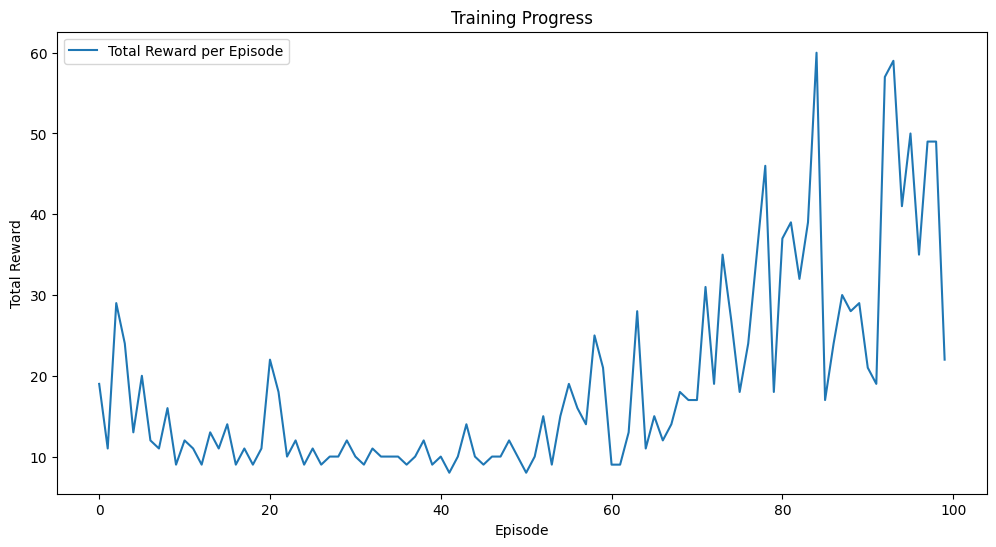

In [10]:
train_agent('CartPole-v1', n_episodes=100)